## On essaye de calculer les forces de pression autour du cylindre 

In [207]:
import numpy as np
import torch 
from model import PINNs
from deepxrte.geometry import Rectangle
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt

In [208]:
# On importe le modèle entrainé

with open("results/2_model_2_case_1_zoom" + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)

model = PINNs(hyper_param)
checkpoint = torch.load('results/2_model_2_case_1_zoom/epoch450'+'/model_weights.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])


/tmp/ipykernel_57641/3672406962.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('results/2_model_2_case_1_zoom/epoch450'+'/model_weights.pth', ma

<All keys matched successfully>

In [209]:
param_adim = {
    'V': 1.,
    'L': 0.025,
    'rho': 1.2
}

In [210]:
X_train, U_train, X_full, U_full, X_border,X_border_test, mean_std = charge_data(hyper_param, param_adim)
X_pred = torch.tensor(X_full, dtype=torch.float32)
U_pred = model(X_pred)
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]


On a pour la force de portance : 

$
\overrightarrow{F_p}=-\int_{\theta=0}^{2\pi}(P(\theta)sin(\theta)rd\theta) \overrightarrow{u_y}
$


Pour la force de trainé :

$
\overrightarrow{F_t}=-\int_{\theta=0}^{2\pi}(P(\theta)cos(\theta)rd\theta) \overrightarrow{u_y}
$

In [211]:
x_min = ((-0.02/param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
x_max = ((0.02/param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
y_min = ((-0.02/param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']
y_max = ((0.02/param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']


In [212]:
masque = ((X_full[:, 0]> x_min) & (X_full[:,0]< x_max) & (X_full[:,1]>y_min) & (X_full[:,1]<y_max))

In [213]:
X_red = X_full[masque]
U_red = U_full[masque]
r = 0.025/2

In [214]:
def P_base(theta, t_ad):
    """Trouve la pression la plus proche en theta et à t"""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    x_ad = ((x / param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
    y_ad = ((y / param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']
    distances = np.linalg.norm(X_red - np.array([x_ad, y_ad, t_ad]), axis=1)
    indice_proche = np.argmin(distances)
    P_dim = ((U_red[indice_proche][2] * mean_std['p_std'] + mean_std['p_mean']))*((param_adim['V']**2)*param_adim['rho'])
    return P_dim

In [215]:
def P(theta, t_ad, model_use=model):
    """Donne la pression prédite par le modèle"""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    x_ad = ((x / param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
    y_ad = ((y / param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']
    P_adim = model_use(torch.tensor([x_ad, y_ad, t_ad], dtype=torch.float32))[2]
    P = ((P_adim * mean_std['p_std'] + mean_std['p_mean']))*((param_adim['V']**2)*param_adim['rho'])
    return P.detach().item()
    

In [216]:
def force_portance(t_ad, N_points=100, model_use=model):
    """Calcul la force de portance au temps t_ad"""
    d_theta = 2 * np.pi / N_points
    sum_integrale = 0
    for theta in np.linspace(0, 2*np.pi, N_points):
        sum_integrale += - P(theta, t_ad, model_use)*np.sin(theta)*r*d_theta
    return sum_integrale

def force_portance_base(t_ad, N_points=100):
    """Calcul la force de portance au temps t_ad de base"""
    d_theta = 2 * np.pi / N_points
    sum_integrale = 0
    for theta in np.linspace(0, 2*np.pi, N_points):
        sum_integrale += - P_base(theta, t_ad)*np.sin(theta)*r*d_theta
    return sum_integrale

## Calcul de la portance sans zoom

In [217]:
portance_base = np.array([force_portance_base(t_) for t_ in np.unique(X_red[:, 2])])
Cp_base = portance_base / (0.5 * param_adim['rho'] * param_adim['V']**2*(2*r))

In [218]:
time = np.linspace(np.unique(X_red[:, 2]).min(), np.unique(X_red[:, 2]).max(), 300)

In [219]:
portance = np.array([force_portance(t_) for t_ in time])
Cp = portance / (0.5 * param_adim['rho'] * param_adim['V']**2*(2*r))

In [220]:
time_1 = (np.unique(X_red[:, 2])*mean_std['t_std'] + mean_std['t_mean'])*(param_adim['L']/param_adim['V'])

In [221]:
time_dim = (time *mean_std['t_std'] + mean_std['t_mean'])*(param_adim['L']/param_adim['V'])

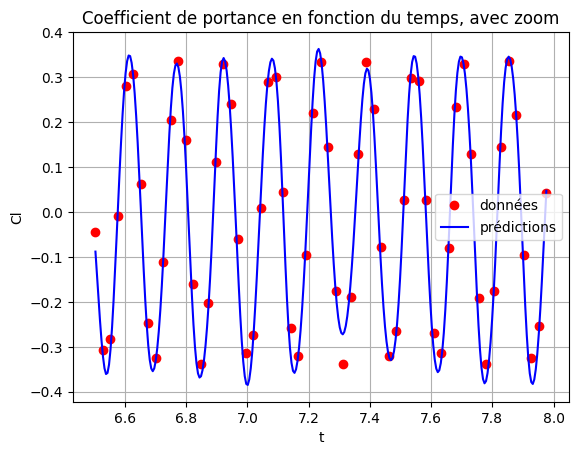

In [227]:
plt.plot(time_1, Cp_base, color='r', marker = 'o', label='données', linestyle='')
plt.plot(time_dim, Cp, color='b', label= 'prédictions')
plt.grid()
plt.xlabel("t")
plt.ylabel('Cl')
plt.title('Coefficient de portance en fonction du temps, avec zoom')
plt.legend()

In [ ]:
## Le modèle zoomé 

In [36]:
# On importe le modèle entrainé

with open("results/2_model_2_case_1_zoom" + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)

model_2 = PINNs(hyper_param)
checkpoint_2 = torch.load('results/2_model_2_case_1_zoom/epoch300'+'/model_weights.pth', map_location=torch.device('cpu'))
model_2.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_30922/3012756827.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_2 = torch.load('results/2_model_2_case_1_zoom/epoch300'+'/model_weights.pth', 

<All keys matched successfully>

In [ ]:



X_train, U_train, X_full, U_full, X_border,X_border_test, mean_std = charge_data(hyper_param, param_adim)
X_pred = torch.tensor(X_full, dtype=torch.float32)
U_pred = model(X_pred)
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]






/tmp/ipykernel_30922/2455853695.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_2 = torch.load('results/2_model_2_case_1_zoom/epoch200'+'/model_weights.pth', 

In [37]:
portance_2 = np.array([force_portance(t, model_use=model_2) for t in time])

In [38]:
Cp_2 = portance_2 / (0.5 * param_adim['rho'] * param_adim['V']**2)

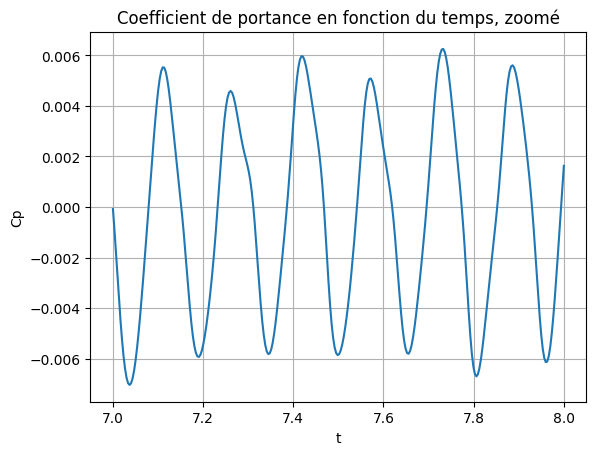

In [39]:
plt.plot(time, Cp_2)
plt.grid()
plt.xlabel("t")
plt.ylabel('Cp')
plt.title('Coefficient de portance en fonction du temps, zoomé')
plt.savefig('coeff_portance_model_2_case_1_zoom.png')

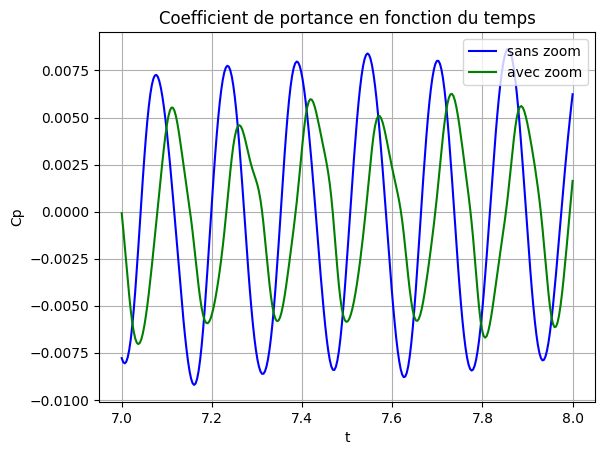

In [40]:
plt.plot(time, Cp, color='blue', label= 'sans zoom')
plt.plot(time, Cp_2, color='green', label= 'avec zoom')
plt.grid()
plt.xlabel("t")
plt.ylabel('Cp')
plt.title('Coefficient de portance en fonction du temps')
plt.legend()
plt.savefig('coeff_portance_model_2_case_1_compare.png')